In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from datetime import datetime
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np
import functools
import warnings
warnings.filterwarnings('ignore')
test_init()

In [3]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [4]:
samples = exp.list_samples()
samples = [x for x in samples if x!= 'sep6']

In [5]:
# GMM
for x in samples:
    hc = Gating(exp, x)
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_lymphocytes', definition='+')
    child_populations.add_population('gmm_lymphocytes_NEG', definition='-')
    pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
    gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                          conf=0.99, transform_x=None, transform_y=None)
    hc.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                   kwargs=gate_definition, child_populations=child_populations)
    hc.apply('gmm_lymphocytes', plot_output=False)
    hc.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


In [6]:
# dbscan
import gc
for x in samples:
    hc = Gating(exp, x)
    if 'dbscan_lymphocytes' in hc.populations.keys():
        continue
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('dbscan_lymphocytes', target=(70000, 40000), weight=1)
    gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.1,
                          transform_x=None, transform_y=None)
    hc.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', method='dbscan',
                   kwargs=gate_definition, child_populations=child_populations)
    hc.apply('dbscan_lymphocytes', plot_output=False)
    hc.save(overwrite=True)
    del hc
    gc.collect()

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


In [7]:
# hdbscan
import gc
for x in samples:
    hc = Gating(exp, x)
    if 'hdbscan_lymphocytes' in hc.populations.keys():
        del hc
        gc.collect()
        continue
    try:
        if 'hdbscan_lymphocytes' in hc.gates.keys():
            hc.gates.pop('hdbscan_lymphocytes')
        child_populations = ChildPopulationCollection('cluster')
        child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
        gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=100, frac=0.01,
                               transform_x=None, transform_y=None)
        hc.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', method='hdbscan',
                       kwargs=gate_definition, child_populations=child_populations)
        hc.apply('hdbscan_lymphocytes', plot_output=False)
        hc.save(overwrite=True)
    except Exception as e:
        print(f'Failed {x}: {e}')
    del hc
    gc.collect()

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Failed hc13: Clustering algorithm failed to identify any clusters (all labels attain to noise) If sampling, try increasing sample size
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


In [10]:
hc = Gating(exp, 'hc13')
if 'hdbscan_lymphocytes' in hc.populations.keys():
    hc.populations.pop('hdbscan_lymphocytes')
try:
    if 'hdbscan_lymphocytes' in hc.gates.keys():
        hc.gates.pop('hdbscan_lymphocytes')
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
    gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=100, frac=0.1,
                           transform_x=None, transform_y=None)
    hc.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', method='hdbscan',
                   kwargs=gate_definition, child_populations=child_populations)
    hc.apply('hdbscan_lymphocytes', plot_output=False)
    hc.save(overwrite=True)
except Exception as e:
    print(f'Failed {x}: {e}')
del hc
gc.collect()

Saved successfully!


4607

In [8]:
# 2DDens
import gc
for x in samples:
    hc = Gating(exp, x)
    if 'dens2d_lymphocytes' in hc.populations.keys():
        hc.populations.pop('dens2d_lymphocytes')
        hc.populations.pop('dens2d_lymphocytes_NEG')
    if 'dens2d_lymphocytes' in hc.gates.keys():
        hc.gates.pop('dens2d_lymphocytes')
    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_lymphocytes', definition='--')
    child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
    gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=1000, transform_x=None, transform_y=None)
    hc.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    hc.apply('dens2d_lymphocytes', plot_output=False)
    hc.save(overwrite=True)
    del hc
    gc.collect()

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


In [14]:
def visualise_manual_ellipse(hc, centroid, width, height, angle, xlim, ylim):
    data = hc.get_population_df('root')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data['FSC-A'], data['SSC-A'], bins=500, norm=LogNorm())
    ellipse = Ellipse(xy=centroid, width=width, height=height,
                              angle=angle, fill=False, edgecolor='r')
    ax.add_patch(ellipse)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

In [113]:
hc = Gating(exp, 'hc19')
for x in ['manual_lymphocytes', 'manual_lymphocytes_NEG']:
    if x in hc.populations.keys():
        hc.populations.pop(x)
if 'manual_lymphocytes' in hc.gates.keys():
    hc.gates.pop('manual_lymphocytes')

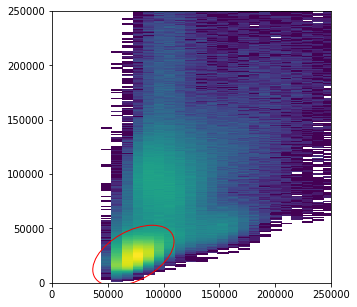

In [117]:
centroid=(73000, 25000)
width=80000
height=45000
angle=30
visualise_manual_ellipse(hc, centroid, width, height, angle, xlim=(0, 250000), ylim=(0,250000))

In [118]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

In [119]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=centroid, width=width, height=height, angle=angle,
                      transform_x=None, transform_y=None)
hc.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

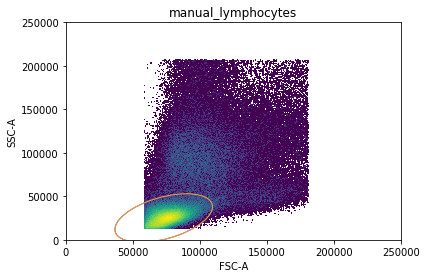

In [120]:
hc.apply('manual_lymphocytes')

In [121]:
hc.save(overwrite=True)

Saved successfully!


True

In [126]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
gating_performance = dict(sample_id=[], population=[], method=[], accuracy=[], f1_score=[],
                         precision=[], recall=[], fpr=[])

def check_performance(hc, manual_pop, auto_pop, method):
    parent = hc.get_population_df(hc.gates[method].parent)
    manual_pop_idx = hc.populations[manual_pop].index
    auto_pop_idx = hc.populations[auto_pop].index
    # Apply function and measure time taken
    gating_performance['sample_id'].append(hc.id)
    if manual_pop == 'lymphocytes':
        gating_performance['populations'].append('lymphocytes')
    else:
        gating_performance['population'].append(manual_pop.split('_')[1])
    gating_performance['method'].append(method)
    
    #Pull data
    parent['manual'], parent['auto'] = 0, 0
    parent['manual'] = parent['manual'].mask(parent.index.isin(manual_pop_idx), 1)
    parent['auto'] = parent['auto'].mask(parent.index.isin(auto_pop_idx), 1)
    
    # Rate performance of result
    recall = recall_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    precision = precision_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    accuracy = accuracy_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    f1 = f1_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    gating_performance['f1_score'].append(f1)
    gating_performance['accuracy'].append(accuracy)
    gating_performance['precision'].append(precision)
    gating_performance['recall'].append(recall)
    tn, fp, fn, tp = confusion_matrix(y_pred=parent['auto'], y_true=parent['manual']).ravel()
    gating_performance['fpr'].append(fp/(fp+tn))

In [127]:
for x in samples:
    print(f'Assessing performance for {x}')
    hc = Gating(exp, x)
    for method in ['gmm', 'dbscan', 'hdbscan', 'dens2d']:
        auto_pop = f'{method}_lymphocytes'
        check_performance(hc, 'manual_lymphocytes', auto_pop, auto_pop)

Assessing performance for hc1
Assessing performance for hc4
Assessing performance for hc5
Assessing performance for hc7
Assessing performance for hc9
Assessing performance for hc10
Assessing performance for hc11
Assessing performance for hc12
Assessing performance for hc13
Assessing performance for hc15
Assessing performance for hc16
Assessing performance for hc17
Assessing performance for hc18
Assessing performance for hc19


In [128]:
def rename_method(x):
    if x.split('_')[0] == 'gmm':
        return 'Gaussian Mixture Model'
    if x.split('_')[0] == 'dbscan':
        return 'DBSCAN'
    if x.split('_')[0] == 'hdbscan':
        return 'HDBSCAN'
    if x.split('_')[0] == 'dens2d':
        return 'Density threshold (2D)'
    return x
results = pd.DataFrame(gating_performance)
results['method'] = results['method'].apply(rename_method)

(0, 1)

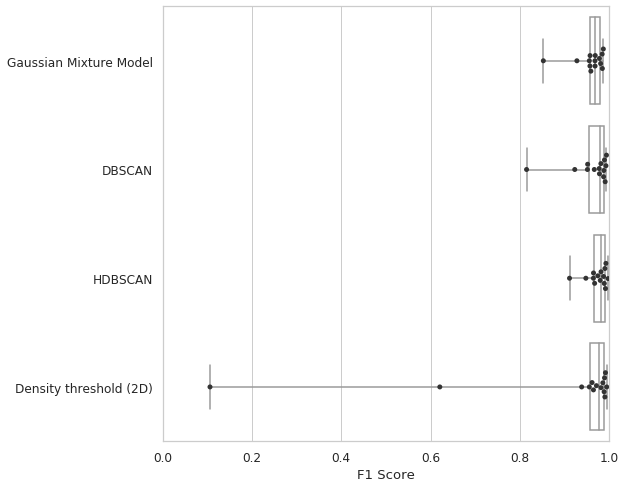

In [130]:
import seaborn as sns
sns.set(font_scale=1.1)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.boxplot(x="f1_score", y="method", data=results, whis=np.inf, color='white')
ax = sns.swarmplot(x="f1_score", y="method", data=results, color='.2')
ax.set_xlabel('F1 Score')
ax.set_ylabel('')
ax.set_xlim(0,1)

In [149]:
hc = Gating(exp, 'hc19')
data = hc.get_population_df('root')

In [150]:
auto_geom = hc.populations['gmm_lymphocytes'].geom
manual_geom = hc.populations['manual_lymphocytes'].geom

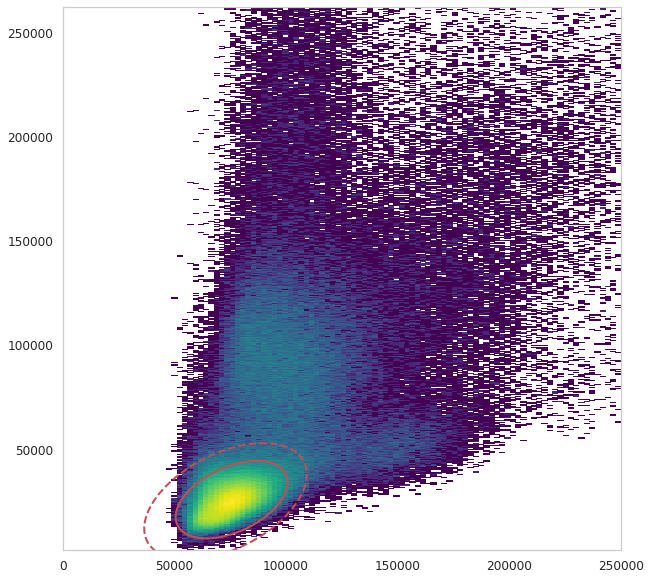

In [153]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist2d(data['FSC-A'], data['SSC-A'], bins=2000, norm=LogNorm(), cmap='viridis')
manual = Ellipse(xy=manual_geom['centroid'], 
                 width=manual_geom['width'], 
                 height=manual_geom['height'],
                 angle=manual_geom['angle'],
                 fill=None, color='r', 
                 linestyle='--', 
                 linewidth=2)
ax.add_patch(manual)
auto = Ellipse(xy=auto_geom['centroid'], 
                 width=auto_geom['width'], 
                 height=auto_geom['height'],
                 angle=auto_geom['angle'],
                 fill=None, color='r',
                 linewidth=2)
ax.set_xlim(0, 250000)
ax.add_patch(auto)
fig.show()

In [ ]:
data